https://github.com/pyg-team/pytorch_geometric/issues/9520

In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install tensorly
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00


In [ ]:
import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn import metrics
from tensorly import decomposition

import torch
from torch.functional import tensordot
from torch import nn, optim, Tensor
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_clu

In [ ]:
print(f"PyTorch has version {torch.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

PyTorch has version 2.4.1+cu121
Torch version: 2.4.1+cu121
Cuda available: False
Torch geometric version: 2.6.1


In [ ]:
rating_threshold = 3
##@param {type: "integer"}: Ratings equal to or greater than 3 are positive items.

config_dict = {
    "num_samples_per_user": 500,
    "num_users": 200,

    "epochs": 100,
    "batch_size": 128,
    "lr": 0.001,
    "weight_decay": 0.1,

    "embedding_size": 64,
    "num_layers": 5,
    "K": 10,
    "mf_rank": 8,

    "minibatch_per_print": 100,
     "epochs_per_print": 1,

    "val_frac": 0.2,
    "test_frac": 0.1,

    "model_name": "model.pth"
}

# Dataset

Tập dữ liệu được sử dụng là MovieLens 1M.
Tập dữ liêu này bao gồm 1 triệu đánh giá từ 1 đến 5.
Tập có 6 nghìn người dùng và 4 nghìn bộ phim

In [ ]:
DATA_PATH = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"

In [ ]:
def trans_ml(dat, thres):
    """
    Transform function that assign non-negative entries >= thres 1, and non-
    negative entries <= thres 0. Keep other entries the same.
    hàm biến đổi dùng để gán những giá trị không âm >= thres là 1, còn lại là 0.
    Những giá trị khác thì giữ nguyên.
    INPUT:
    dat: Data object
    thres: threshold
    return: Data object
    """
    # lấy giá trị trần làm mốc phân biệt
    thres = thres[0]
    # lấy ma trận chỉ mục của cạnh
    matrix = dat['edge_index']
    # cập nhật ma trận
    matrix[(matrix < thres) & (matrix > -1)] = 0
    matrix[(matrix >= thres)] = 1

    # gán lại ma trận vào từ điển
    dat['edge_index'] = matrix
    return dat


class MovieLens(Dataset):
  '''
  MovieLens class extends Dataset class
  '''
  def __init__(self, root, transform=None, pre_transform=None,
          transform_args=None, pre_transform_args=None):
      """
      root = where the dataset should be stored. This folder is split
      into raw_dir (downloaded dataset) and processed_dir (process data).
      root: thư mục chứa dữ liệu, bao gồm 2 thư mục raw_dir và processed_dir

      transform, transform_args, pre_transform, and pre_transform_args
      are passed to the call of the super class.
      transform, transform_args, pre_transform, và pre_transform_args
      được truyền vào khi gọi lớp cha "Dataset"
      Dataset là 1 phần của torch_geometric.data
      https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.data.Dataset.html


      Args:
          root (string): Root directory
          transform (callable, optional): A function/transform that takes in
              an Data object and returns a transformed version.
              The data object will be transformed before every access.
              (default: :obj:`None`)
          pre_transform (callable, optional): A function/transform that takes
              in an Data object and returns a transformed version. The data
              object will be transformed before every access.
              (default: :obj:`None`)


      """
      super(MovieLens, self).__init__(root, transform, pre_transform)
      self.transform = transform
      self.pre_transform = pre_transform
      self.transform_args = transform_args
      self.pre_transform_args = pre_transform_args

  @property
  def raw_file_names(self):
      return "ml-1m.zip"

  @property
  def processed_file_names(self):
      return ["data_movielens.pt"]

  def download(self):
      # Download to `self.raw_dir`.
      # dowload_url là 1 phần của torch_geometric.data
      download_url(DATA_PATH, self.raw_dir)

  def _load(self):
      print(self.raw_dir)
      # extract_zip(self.raw_paths[0], self.raw_dir)
      with zipfile.ZipFile(self.raw_paths[0], 'r') as zip_ref:
          zip_ref.extractall(self.raw_dir)

      unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
      users = pd.read_table(self.raw_dir+'/ml-1m/users.dat',
                            sep='::', header=None, names=unames,
                            engine='python', encoding='latin-1')
      rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
      ratings = pd.read_table(self.raw_dir+'/ml-1m/ratings.dat', sep='::',
                              header=None, names=rnames, engine='python',
                              encoding='latin-1')
      mnames = ['movie_id', 'title', 'genres']
      movies = pd.read_table(self.raw_dir+'/ml-1m/movies.dat', sep='::',
                              header=None, names=mnames, engine='python',
                              encoding='latin-1')
      # tạo ma trận
      dat = pd.merge(pd.merge(ratings, users), movies)

      return users, ratings, movies, dat

  def process(self):
      print('run process')
      # load information from file
      users, ratings, movies, dat = self._load()

      users = users['user_id']
      movies = movies['movie_id']

      num_users = config_dict["num_users"]
      # lọc bớt các đỉnh người dùng nếu cần thiết
      if num_users != -1:
          users = users[:num_users]

      user_ids = range(len(users))
      movie_ids = range(len(movies))

      user_to_id = dict(zip(users, user_ids))
      movie_to_id = dict(zip(movies, movie_ids))

      # get adjacency info
      # lấy số đỉnh người dùng và số đỉnh sản phẩm
      self.num_user = users.shape[0]
      self.num_item = movies.shape[0]

      # initialize the adjacency matrix
      # khởi tạo ma trận kề với hàng là người dùng, cột là sản phẩm bộ phim
      rat = torch.zeros(self.num_user, self.num_item)

      # với mỗi dòng
      for index, row in ratings.iterrows():
          user, movie, rating = row[:3]
          if num_users != -1:
            # bỏ qua nếu người dùng đang được xét không có trong danh sách
            # đang được quan tâm hoặc đây là 1 đoạn dữ liệu bị lỗi
            if user not in user_to_id: break
          # create ratings matrix where (i, j) entry represents the ratings
          # of movie j given by user i.
          # điền tỉ lệ đánh giá vào ma trận kề
          rat[user_to_id[user], movie_to_id[movie]] = rating

      # create Data object
      data = Data(edge_index = rat,
                  raw_edge_index = rat.clone(),
                  data = ratings,
                  users = users,
                  items = movies)

      # apply any pre-transformation
      if self.pre_transform is not None:
          data = self.pre_transform(data, self.pre_transform_args)

      # apply any post_transformation
      # if self.transform is not None:
      #     # data = self.transform(data, self.transform_args)
      # cụ thể ở đây đang gọi hàm trans_ml được định nghĩa ở mục trên cùng
      data = self.transform(data, [rating_threshold])

      # save the processed data into .pt file
      torch.save(data, osp.join(self.processed_dir, f'data_movielens.pt'))
      print('process finished')


  def get(self):
      """
      The logic to load a single graph
      """
      data = torch.load(osp.join(self.processed_dir, 'data_movielens.pt'))
      return data

  def train_val_test_split(self, val_frac=0.2, test_frac=0.1):
      """
      Return two mask matrices (M, N) that represents edges present in the
      train and validation set
      Trả về 2 mặt nạ đánh dấu những cạnh có trong tập huấn luyện và tập
      kiếm tra
      những cạnh đó sẽ được lựa chọn ngẫu nhiên trong tập dữ liệu

      """
      try:
          self.num_user, self.num_item
      except AttributeError:
          data = self.get()
          self.num_user = len(data["users"].unique())
          self.num_item = len(data["items"].unique())
      # get number of edges masked for training and validation
      num_train_replaced = \
          round((test_frac+val_frac)*self.num_user*self.num_item)
      num_val_show = round(val_frac*self.num_user*self.num_item)

      # edges masked during training
      indices_user = np.random.randint(0, self.num_user, num_train_replaced)
      indices_item = np.random.randint(0, self.num_item, num_train_replaced)

      # sample part of edges from training stage to be unmasked during
      # validation
      indices_val_user = np.random.choice(indices_user, num_val_show)
      indices_val_item = np.random.choice(indices_item, num_val_show)

      train_mask = torch.ones(self.num_user, self.num_item)
      train_mask[indices_user, indices_item] = 0

      val_mask = train_mask.clone()
      val_mask[indices_val_user, indices_val_item] = 1

      test_mask = torch.ones_like(train_mask)

      return train_mask, val_mask, test_mask

# Cài đặt LightGCN

## Tầng tính toán lân cận theo LightGCN

Bắt đầu với tầng khởi tạo $E^0$ và đồ thị phân đôi, chúng ta
duyệt qua các đỉnh và tiến hành thu thập thông tin từ các lân cận của mỗi đỉnh.
Chúng ta cần lưu ý rằng LightGCN **sử dụng phép cộng trọng số thay cho việc sử dụng phép biến đổi đặc trưng, và hàm kích hoạt tuyến tính**.

Tại mỗi tầng xử lý, từ mỗi đỉnh thuộc nhóm người dùng, chúng ta tính toán giá
 trị mới của vectơ nhúng thông qua sử dụng các
 giá trị từ các vectơ lận cận với nó "cụ thể là các vectơ nhúng đại diện cho các bộ phim
  mà người dùng này đã từng tương tác "

  $$e_i^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|} \sqrt{|N_i|}} \textbf{e}_i^{(k)}$$

  tại đó $e_u^{(k)}$ và $e_i^{(k)}$ là các véc tơ nhúng đại diện cho các đỉnh người dùng và đỉnh bộ phim tại tần thứ k.
  $ |N_u| $ và $ |N_i|$ là số lượng tương ứng các đỉnh đại diện cho người dùng và bộ phim trên phần đồ thị đang được xét,
  ở đây có thể là toàn bộ đồ thị hoặc các đỉnh trong cụm đỉnh đạng được xét trong batch xử lý  

  Tương tự như vậy, với mỗi đỉnh thuộc nhóm bộ phim, giá trị véc tơ nhúng được cập nhật thông qua
  giá trị của các véc tơ nhúng của người dùng lân cận với nó
  $$ \textbf{e}_i^{(k+1)} = \sum_{i \in N_i} \frac{1}{\sqrt{|N_i|} \sqrt{|N_u|}} \textbf{e}_u^{(k)} $$


In [ ]:
class LightGCNConv(MessagePassing):
    r"""The neighbor aggregation operator from the `"LightGCN: Simplifying and
    Powering Graph Convolution Network for Recommendation"
    <https://arxiv.org/abs/2002.02126#>`_ paper
    phái sinh từ lớp MessagePassing
    https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html

    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        num_users (int): Number of users for recommendation.
        num_items (int): Number of items to recommend.
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int, **kwargs):
        super(LightGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.num_users = num_users
        self.num_items = num_items

        self.reset_parameters()

    def reset_parameters(self):
        pass  # There are no layer parameters to learn.

    def forward(self, x: Tensor, edge_index: Adj) -> Tensor:
        """Performs neighborhood aggregation for user/item embeddings."""
        # thiết lập ma trận kề
        user_item = \
                torch.zeros(self.num_users, self.num_items, device=x.device)

        # nếu điểm nào đại diện cho kết nối giữa người dùng và
        # sản phẩm thì đặt nó là 1
        user_item[edge_index[:, 0], edge_index[:, 1]] = 1

        # đếm tổng số lân cận của người dùng
        user_neighbor_counts = torch.sum(user_item, axis=1)
        # đếm tổng số lân cận của sản phẩm
        item_neightbor_counts = torch.sum(user_item, axis=0)

        # Compute weight for aggregation: 1 / sqrt(N_u * N_i)
        weights = user_item / torch.sqrt(
                user_neighbor_counts.repeat(self.num_items, 1).T \
                * item_neightbor_counts.repeat(self.num_users, 1))

        # chuẩn hóa trọng số. biến nan thành 0
        weights = torch.nan_to_num(weights, nan=0)

        # inner product
        out = torch.concat((weights.T @ x[:self.num_users],
                            weights @ x[self.num_users:]), 0)
        return out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


#Mô hình LightGCN

Tại bước cuối, chúng ta kết hợp các tầng với nhau,
thông thường thì các mô hình khác lấy véc tơ trọng số của tầng cuối cùng, song LightGCN sẽ lấy. **tổng các véc tơ trọng số của các tầng**.   
$$ \textbf{e}_u = \sum_{k=0}^K \alpha_k \textbf{e}_u^{(k)} $$
$$ \textbf{e}_i = \sum_{k=0}^K \alpha_k \textbf{e}_i^{(k)} $$

với giá trị $\alpha > 0$. Tại đây, alpha có thể là 1 biến thay đổi được trong quá trình huấn luyện hoặc được thiết lập sẵn từ trước. Thực nghiệm cho thấy giá trị $ \alpha = \frac{1}{K + 1} $  phù hợp cho đa số trường hợp sử dụng.

Các dự báo của LightGCN dựa trên phép tính tích bên trong của 2 vectơ nhúng đại diện cho 1 người dùng và 1 bộ phim.
$$\hat{y}_{ui} = \textbf{e}_u^T \textbf{e}_i $$

Tích này đó lường độ tương tự giữa người dùng và bộ phim, từ đó cho phép chúng ta nắm được xác suất người dùng có thể tương tác với bộ phim




In [ ]:
# for inter-layer combination
class LightGCN(nn.Module):
    def __init__(self,
                 config: dict,
                 device=None,
                 **kwargs):
        super().__init__()

        self.num_users  = config["n_users"]
        self.num_items  = config["m_items"]
        self.embedding_size = config["embedding_size"]
        self.in_channels = self.embedding_size
        self.out_channels = self.embedding_size
        self.num_layers = config["num_layers"]

        # 0-th layer embedding.
        self.embedding_user_item = torch.nn.Embedding(
            num_embeddings=self.num_users + self.num_items,
            embedding_dim=self.embedding_size)
        self.alpha = None

        # random normal init seems to be a better choice when lightGCN actually
        # don't use any non-linear activation function
        nn.init.normal_(self.embedding_user_item.weight, std=0.1)
        print('use NORMAL distribution initilizer')

        self.f = nn.Sigmoid()

        self.convs = nn.ModuleList()
        self.convs.append(LightGCNConv(
                self.embedding_size, self.embedding_size,
                num_users=self.num_users, num_items=self.num_items, **kwargs))

        # các tầng còn lại
        # mỗi tầng là 1 hop trong việc tính các lân cận
        for _ in range(1, self.num_layers):
            self.convs.append(
                LightGCNConv(
                        self.embedding_size, self.embedding_size,
                        num_users=self.num_users, num_items=self.num_items,
                        **kwargs))

        self.device = None
        if device is not None:
            self.convs.to(device)
            self.device = device

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj, *args, **kwargs) -> Tensor:
        xs: List[Tensor] = []

        #
        edge_index = torch.nonzero(edge_index)
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, *args, **kwargs)
            if self.device is not None:
                x = x.to(self.device)
            xs.append(x)

        # stack all result
        xs = torch.stack(xs)

        # tính giá trị alpha, alpha là 1 vec-tơ
        self.alpha = 1 / (1 + self.num_layers) * torch.ones(xs.shape)
        if self.device is not None:
            self.alpha = self.alpha.to(self.device)
            xs = xs.to(self.device)

        # tính tổng cuối cùng
        x = (xs * self.alpha).sum(dim=0)  # Sum along K layers.
        return x

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_layers={self.num_layers})')

#Hàm bổ trợ
các hàm hỗ trợ lấy giá trị nhúng và tính toán độ tương tự giữa người dùng và bộ phim

In [ ]:
def getUsersRating(model, users, data):
    """ Get the embedding of users
    lấy độ tương tự giữa người dùng và bộ phim
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        data: the entire data, used to fetch all users and all items
    """
    all_users_items = model(model.embedding_user_item.weight.clone(),
                            data["edge_index"])
    all_users = all_users_items[:len(data["users"])]
    items_emb = all_users_items[len(data["users"]):]
    users_emb = all_users[users.long()]
    # LightGCN sử dụng phép toán nhân đơn giản
    rating = model.f(torch.matmul(users_emb, items_emb.t()))
    return rating

def getEmbedding(model, users, pos, neg, data, mask):
    """
    lấy những giá trị nhúng tương ứng từ tầng tính toán trước đó
    để huấn luyện mô hình LightGCN
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        pos: positive index corresponding to an item that the user like
        neg: negative index corresponding to an item that the user doesn't like
        data: the entire data, used to fetch all users and all items
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
    """
    # assuming we always search for users and items by their indices (instead of
    # user/item number)

    all_users_items = model(model.embedding_user_item.weight.clone(),
                            data["edge_index"] * mask)
    all_users = all_users_items[:len(data["users"])]
    all_items = all_users_items[len(data["users"]):]
    users_emb = all_users[users]
    pos_emb = all_items[pos]
    neg_emb = all_items[neg]
    n_user = len(data["users"])
    users_emb_ego = model.embedding_user_item(users)
    # offset the index to fetch embedding from user_item
    pos_emb_ego = model.embedding_user_item(pos + n_user)
    neg_emb_ego = model.embedding_user_item(neg + n_user)
    return users_emb, pos_emb, neg_emb, users_emb_ego, pos_emb_ego, neg_emb_ego

## Bayesian Personalized Ranking loss (BPR loss)

Nhằm huấn luyện mô hìn LightGCN, chúng ta cần một hàm số đáp ứng bài toán đề xuất bộ phim phù hợp. Chúng ta sử dụng Bayesian Personalized Ranking loss (BPR loss), hàm mất mát này đáp ứng yêu cầu của bài toán dự báo cạnh kết nối giữa người dùng và bộ phim, nếu có kết nối thì giá trị trả về sẽ cao hơn khi không có kết nối, chúng ta áp dụng chuẩn Euclider hay còn gọi là $L_2$
$$L_{BPR} = - \sum_{u=1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||\textbf{E}^{(0)} ||^2$$
với $E^{(0)}$ là ma trận với các véc tơ cột là giá trị nhúng của tầng 0, "vec tơ đặc trưng của mỗi đỉnh:

In [ ]:
def bpr_loss(model, users, pos, neg, data, mask):
    """
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        pos: positive index corresponding to an item that the user like
            (0-indexed, note to index items starting from 0)
        neg: negative index corresponding to an item that the user doesn't like
        data: the entire data, used to fetch all users and all items
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
    OUTPUT:
        loss, reg_loss
    """
    # assuming we always sample the same number of positive and negative sample
    # per user
    # đảm bảo rằng tập huấn luyện cân bằng
    assert len(users) == len(pos) and len(users) == len(neg)
    (users_emb, pos_emb, neg_emb,
    userEmb0,  posEmb0, negEmb0) = getEmbedding(model, users.long(), pos.long(),
                                                neg.long(), data, mask)

    reg_loss = (1/2)*(userEmb0.norm(2).pow(2) +
                        posEmb0.norm(2).pow(2)  +
                        negEmb0.norm(2).pow(2))/float(len(users))

    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    # https://pytorch.org/docs/stable/generated/torch.nn.functional.softplus.html

    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

    return loss, reg_loss

In [ ]:
def personalized_topk(pred, K, user_indices, edge_index):
    """Computes TopK precision and recall.

    Args:
        pred: Predicted similarities between user and item.
        K: Number of items to rank.
        user_indices: Indices of users for each prediction in `pred`.
        edge_index: User and item connection matrix.

    Returns:
        Average Top K precision and recall for users in `user_indices`.
    """
    per_user_preds = collections.defaultdict(list)
    for index, user in enumerate(user_indices):
        per_user_preds[user.item()].append(pred[index].item())
    precisions = 0.0
    recalls = 0.0
    for user, preds in per_user_preds.items():
        while len(preds) < K:
            preds.append(random.choice(range(edge_index.shape[1])))
        top_ratings, top_items = torch.topk(torch.tensor(preds), K)
        # lấy số dự đoán đúng
        correct_preds = edge_index[user, top_items].sum().item()
        # tống số dự đoán gốc
        total_pos = edge_index[user].sum().item()
        # bổ sung vào giá trị precision
        precisions += correct_preds / K

        recalls += correct_preds / total_pos if total_pos != 0 else 0
    num_users = len(user_indices.unique())
    return precisions / num_users, recalls / num_users

## Lấy mẫu

với mỗi người dùng, chúng ta chọn ngẫu nhiên n mẫu bộ phim bao gồm cả mẫu có tương tác và mẫu không tương tác với người dùng sau đó cho vào danh sách huấn luyện, xác thực hoặc kiểm tra, thông số n sẽ được tinh chỉnh thủ công


In [ ]:
def _sample_pos_neg(data, mask, num_samples_per_user):
    """Samples (user, positive item, negative item) tuples per user.

    If a user does not have a postive (negative) item, we choose an item
    with unknown liking (an item without raw rating data).

    Args:
        data: Dataset object containing edge_index and raw ratings matrix.
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
        num_samples_per_user: Number of samples to generate for each user.

    Returns:
        torch.Tensor object of (user, positive item, negative item) samples.
    """
    print("=====Starting to sample=====")
    start = time.time()
    samples = []
    all_items = set(range(len(data["items"])))
    for user_index, user in enumerate(data["users"]):
        pos_items = set(
            torch.nonzero(data["edge_index"][user_index])[:, 0].tolist())
        unknown_items = all_items.difference(
                set(
                    torch.nonzero(
                        data["raw_edge_index"][user_index])[:, 0].tolist()))
        neg_items = all_items.difference(
            set(pos_items)).difference(set(unknown_items))
        unmasked_items = set(torch.nonzero(mask[user_index])[:, 0].tolist())
        if len(unknown_items.union(pos_items)) == 0 or \
                len(unknown_items.union(neg_items)) == 0:
            continue
        for _ in range(num_samples_per_user):
            if len(pos_items.intersection(unmasked_items)) == 0:
                pos_item_index = random.choice(
                    list(unknown_items.intersection(unmasked_items)))
            else:
                pos_item_index = random.choice(
                    list(pos_items.intersection(unmasked_items)))
            if len(neg_items.intersection(unmasked_items)) == 0:
                neg_item_index = random.choice(
                    list(unknown_items.intersection(unmasked_items)))
            else:
                neg_item_index = random.choice(
                    list(neg_items.intersection(unmasked_items)))
            samples.append((user_index, pos_item_index, neg_item_index))
    end = time.time()
    print(f"=====Sampling completed (took {end - start} seconds)=====")
    return torch.tensor(samples, dtype=torch.int32)

def sample_pos_neg(data, train_mask, val_mask, test_mask, num_samples_per_user):
    """Samples (user, positive item, negative item) tuples per user.

    If a user does not have a postive (negative) item, we choose an item
    with unknown liking (an item without raw rating data).

    Args:
        data: Dataset object containing edge_index and raw ratings matrix.
        train_mask: Masking matrix indicating edges present in train set.
        val_mask: Masking matrix indicating edges present in validation set.
        test_mask: Masking matrix indicating edges present in test set.
        num_samples_per_user: Number of samples to generate for each user.

    Returns:
        torch.Tensor object of (user, positive item, negative item) samples for
        train, validation and test.
    """
    train_samples = _sample_pos_neg(data, train_mask, num_samples_per_user)
    val_samples = _sample_pos_neg(data, val_mask, num_samples_per_user)
    test_samples = _sample_pos_neg(data, test_mask, num_samples_per_user)
    return train_samples, val_samples, test_samples

# Huấn luyện và đánh giá kết quả

In [ ]:
root = os.getcwd()
movielens = MovieLens(root=root, transform=trans_ml)
data = movielens.get()
train_mask, val_mask, test_mask = \
        movielens.train_val_test_split(val_frac=config_dict["val_frac"],
                                       test_frac=config_dict["test_frac"])

n_users = len(data["users"].unique())
m_items = len(data["items"].unique())
print(f"#Users: {n_users}")
print(f"#Items: {m_items}")

model_config = {
    "n_users": n_users,
    "m_items": m_items,
    "embedding_size": config_dict["embedding_size"],
    "num_layers": config_dict["num_layers"],
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightGCN = LightGCN(model_config, device=device)

num_samples_per_user = config_dict["num_samples_per_user"]
epochs = config_dict["epochs"]
batch_size = config_dict["batch_size"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]

K = config_dict["K"]

lightGCN.to(device)

samples_train, samples_val, samples_test = \
        sample_pos_neg(data, train_mask, val_mask, test_mask,
                       num_samples_per_user)

samples_train=samples_train.to(device)
samples_val=samples_val.to(device)
samples_test=samples_test.to(device)
train_mask=train_mask.to(device)
val_mask=val_mask.to(device)
test_mask=test_mask.to(device)
data = data.to(device)

print(f"#Training samples: {len(samples_train)}",
      f"#Validation samples: {len(samples_val)}",
      f"#Test samples: {len(samples_test)}")

optimizer = optim.Adam(lightGCN.parameters(), lr=lr)
print("Optimizer:", optimizer)

epochs_tracked = []
train_topks = []
val_topks = []

for epoch in range(epochs):
    print("Training on the {} epoch".format(epoch))
    lightGCN.train()
    loss_sum = 0
    # Shuffle the order of rows.
    samples_train = samples_train[torch.randperm(samples_train.size()[0])]
    for batch_idx in range(math.ceil(len(samples_train) / batch_size)):
        optimizer.zero_grad()

        current_batch = \
            samples_train[batch_idx*batch_size: (batch_idx+1)*batch_size]
        # Shuffle the order of rows.
        current_batch = current_batch[torch.randperm(current_batch.size()[0])]
        users = current_batch[:, 0:1]
        pos = current_batch[:, 1:2]
        neg = current_batch[:, 2:3]

        # tính toán mất mát
        loss, reg_loss = bpr_loss(lightGCN, users, pos, neg, data,
                                  train_mask)

        reg_loss = reg_loss * weight_decay
        loss = loss + reg_loss
        loss_sum += loss.detach()

        # cập nhật tham số mô hình
        loss.backward()
        optimizer.step()

        if batch_idx % config_dict["minibatch_per_print"] == 0:
            all_users = torch.linspace(start=0,
                                       end=n_users - 1, steps=n_users).long()
            user_indices = current_batch[:, 0]
            user_indices = user_indices.repeat(2).long()
            item_indices = torch.cat(
                (current_batch[:, 1], current_batch[:, 2])).long()
            pred = getUsersRating(lightGCN,
                                  all_users,
                                  data)[user_indices, item_indices]
            truth = data["edge_index"][user_indices, item_indices]
            topk_precision, topk_recall = \
                personalized_topk(pred, K, user_indices, data["edge_index"])

            print("Training on epoch {} minibatch {}/{} completed\n".format(epoch, batch_idx+1,
                                                                            math.ceil(len(samples_train) / batch_size)),
                  "bpr_loss on current minibatch is {}, and regularization loss is {}.\n".format(round(float(loss.detach().cpu()), 6),
                                                                                                 round(float(reg_loss.detach().cpu()), 6)),
                  "Top K precision = {}, recall = {}.".format(topk_precision, topk_recall))

    if epoch % config_dict["epochs_per_print"] == 0:
        epochs_tracked.append(epoch)

        # evaluation on both the trainisng and validation set
        lightGCN.eval()
        # predict on the training set
        users = samples_train[:, 0:1]
        user_indices = samples_train[:, 0]
        user_indices = user_indices.repeat(2).long()
        item_indices = torch.cat(
            (samples_train[:, 1], samples_train[:, 2])).long()
        pred = getUsersRating(lightGCN,
                              users[:,0],
                              data)[user_indices, item_indices]
        truth = data["edge_index"][users.long()[:,0]]\
            [user_indices, item_indices]
        train_topk_precision, train_topk_recall = \
            personalized_topk(pred, K, user_indices, data["edge_index"])
        train_topks.append((train_topk_precision, train_topk_recall))

        # predict on the validation set
        users_val = samples_val[:, 0:1]
        pos_val = samples_val[:, 1:2]
        neg_val = samples_val[:, 2:3]

        loss_val, reg_loss_val = bpr_loss(
            lightGCN, users_val, pos_val, neg_val, data, val_mask)
        reg_loss_val = reg_loss_val * weight_decay

        # predict on the validation set
        user_indices = samples_val[:, 0]
        user_indices = user_indices.repeat(2).long()
        item_indices = torch.cat((samples_val[:, 1], samples_val[:, 2])).long()
        pred_val = getUsersRating(lightGCN,
                                  users_val[:,0],
                                  data)[user_indices, item_indices]
        truth_val = data["edge_index"][users_val.long()[:,0]]\
            [user_indices, item_indices]
        val_topk_precision, val_topk_recall = \
            personalized_topk(pred_val, K, user_indices, data["edge_index"])
        val_topks.append((val_topk_precision, val_topk_recall))

        print("\nTraining on {} epoch completed.\n".format(epoch),
              "Average bpr_loss on train set is {} for the current epoch.\n".format(round(float(loss_sum/len(samples_train)), 6)),
              "Training top K precision = {}, recall = {}.\n".format(train_topk_precision, train_topk_recall),
              "Average bpr_loss on the validation set is {}, and regularization loss is {}.\n".format(round(float((loss_val+reg_loss_val)/len(samples_val)), 6),
                                                                                                      round(float(reg_loss_val/len(samples_val)), 6)),
              "Validation top K precision = {}, recall = {}.\n".format(val_topk_precision, val_topk_recall))

Processing...


run process
/content/raw
process finished


Done!
<ipython-input-6-068253b50276>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, 'data_movielens.pt'))


#Users: 200
#Items: 3883
use NORMAL distribution initilizer
=====Starting to sample=====
=====Sampling completed (took 5.763131141662598 seconds)=====
=====Starting to sample=====
=====Sampling completed (took 2.8261168003082275 seconds)=====
=====Starting to sample=====
=====Sampling completed (took 3.9228827953338623 seconds)=====
#Training samples: 100000 #Validation samples: 100000 #Test samples: 100000
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Training on the 0 epoch
Training on epoch 0 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.790049, and regularization loss is 0.096902.
 Top K precision = 0.09450549450549449, recall = 0.007693243285111315.
Training on epoch 0 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.738869, and regularization loss is 0.045721.
 Top K

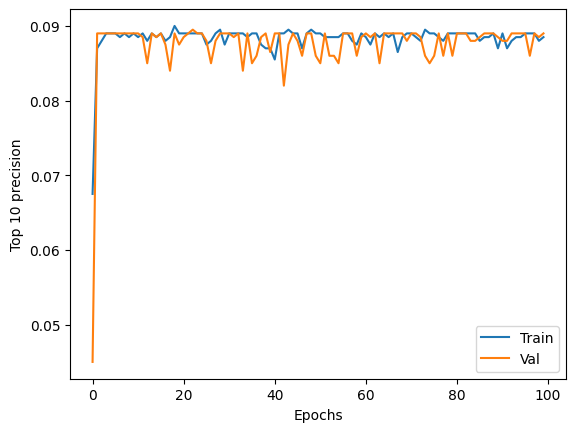

In [ ]:
# https://www.evidentlyai.com/ranking-metrics/precision-recall-at-k
plt.plot(epochs_tracked, [precision for precision, _ in train_topks],
         label="Train")
plt.plot(epochs_tracked, [precision for precision, _ in val_topks],
         label="Val")
plt.ylabel(f"Top {K} precision")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
# predict on the test set
lightGCN.eval()
print("Training completed after {} epochs".format(epochs))

users_test = samples_test[:, 0:1]
pos_test = samples_test[:, 1:2]
neg_test = samples_test[:, 2:3]

loss_test, reg_loss_test = bpr_loss(
    lightGCN, users_test, pos_test, neg_test, data, test_mask)
reg_loss_test = reg_loss_test * weight_decay

# predict on the test set
user_indices = samples_test[:, 0]
user_indices = user_indices.repeat(2).long()
item_indices = torch.cat((samples_test[:, 1], samples_test[:, 2])).long()
pred_test = getUsersRating(lightGCN, users_test[:,0], data)\
    [user_indices, item_indices]
truth_test = data["edge_index"][users_test.long()[:,0]]\
    [user_indices, item_indices]
test_topk_precision, test_topk_recall = personalized_topk(
    pred_test, K, user_indices, data["edge_index"])

print("Average bpr_loss on the test set is {}, and regularization loss is {}.\n".format(round(float((loss_test+reg_loss_test)/len(samples_test)), 6),
                                                                                                round(float(reg_loss_test/len(samples_test)), 6)),
      "Top K precision = {}, recall = {}.".format(test_topk_precision, test_topk_recall))

# Save model embeddings.
torch.save(lightGCN, config_dict["model_name"])

Training completed after 100 epochs
Average bpr_loss on the test set is 7e-06, and regularization loss is 0.0.
 Top K precision = 0.08799999999999995, recall = 0.0075343222497241645.
